<a href="https://colab.research.google.com/github/rcbusinesstechlab/realtime-face-recognition/blob/main/OK_brain_tumor_segmentation_Unet_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [4]:
!bash brain-tumor-segmentation-unet/download_data.sh
!python brain-tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/

3064
/content/brain-tumor-segmentation-unet/mat_to_numpy.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(mat_file[0]))
[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


In [ ]:
# import os
#import numpy as np
#import matplotlib.pyplot as plt
#import cv2

#integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
#labels = np.load('brain_tumor_dataset/labels.npy')
#images = np.clip( (np.load('brain_tumor_dataset/images.npy')/12728),0,1)
#masks = np.load('brain_tumor_dataset/masks.npy')*1
#print(labels.shape)
#print(images.shape)
#print(masks.shape)

Labels shape: (3064,)
Images shape: (3064, 512, 512)
Masks shape: (3064, 512, 512)


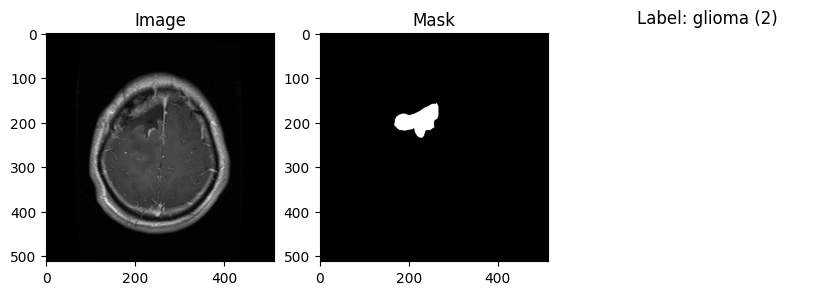

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

# Load data using memory mapping (no full load into RAM)
labels = np.load('brain_tumor_dataset/labels.npy', mmap_mode='r')
images = np.load('brain_tumor_dataset/images.npy', mmap_mode='r')
masks = np.load('brain_tumor_dataset/masks.npy', mmap_mode='r')

# Print shapes (only metadata, no RAM use)
print("Labels shape:", labels.shape)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Example: Access and process only one image/mask/label to avoid memory spike
index = 0  # change index as needed

# Access one sample safely
image = np.clip(images[index] / 12728.0, 0, 1)
mask = masks[index] * 1  # safe for a single slice
label = labels[index]

# Display the sample
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title(f"Label: {integer_to_class[str(label)]}")
plt.show()



In [2]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


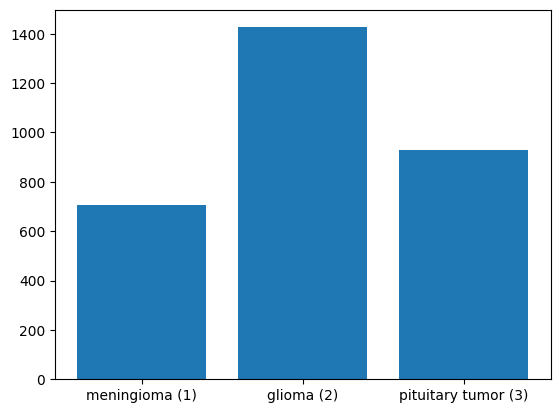

In [3]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

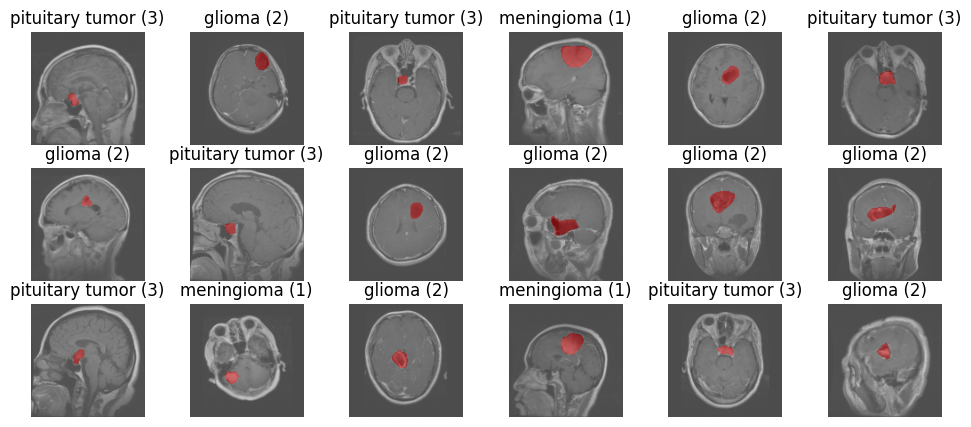

In [4]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

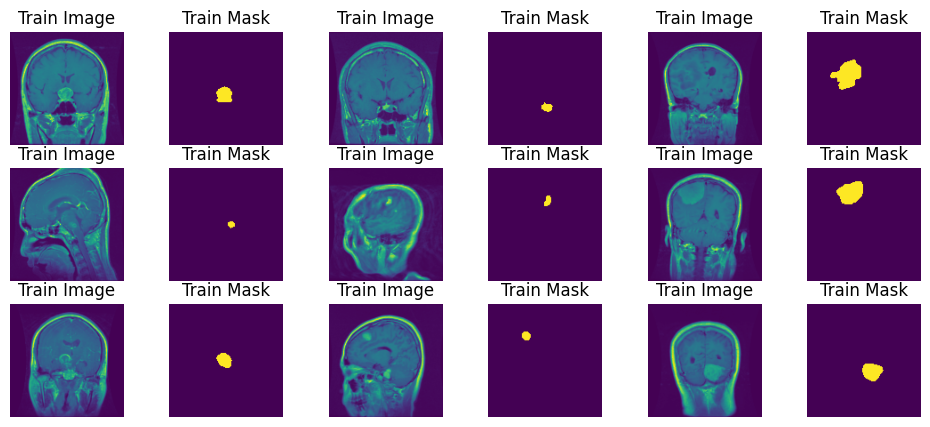

In [5]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1))
  plt.title("Train Mask")
  plt.axis('off')

In [6]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

### Augmentation

In [ ]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [8]:
#from keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
#                                   zoom_range=[.9,1.1],
#                                   fill_mode='nearest')
#val_datagen = ImageDataGenerator()

In [9]:
# Try importing ImageDataGenerator from tensorflow.keras
try:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
except ImportError:
    # If that fails, fall back to the old location for older installations
    print("Could not import ImageDataGenerator from tensorflow.keras. Trying keras.preprocessing.image...")
    from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

### Defining Dice Loss
Dice = 2|A∩B|/|A|+|B|

In [10]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu", name=name+'_1')(input_tensor)

  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu",name=name+'_2')(x)
  return x


inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_1     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_2     │ (None, 128, 128,  │     36,928 │ contraction_1_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ contraction_1_2[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_1   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_2   │ (None, 64, 64,    │    147,584 │ contraction_2_1_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ contraction_2_1_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_1   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_2   │ (None, 32, 32,    │    590,080 │ contraction_3_1_… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ contraction_3_1_… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_4_1_1   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0] 

 Total params: 22,718,529 (86.66 MB)

 Trainable params: 22,716,609 (86.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Defining IOU metric and compile Model

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# TensorFlow-safe IoU metric
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-10) / (union + 1e-10)
    return iou

# Compile your model
unet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=bce_dice_loss,  # Make sure this is a valid loss function
    metrics=['accuracy', iou_metric]
)


In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)

hist = unet.fit(X,Y,batch_size=32,epochs=100,
               validation_data=(X_v,Y_v),verbose=1,callbacks= callback_list)

#unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.9006 - iou_metric: 0.0088 - loss: 38.2187
Epoch 1: val_loss improved from inf to 1.85190, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9013 - iou_metric: 0.0089 - loss: 37.9262 - val_accuracy: 0.9807 - val_iou_metric: 0.0048 - val_loss: 1.8519 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9652 - iou_metric: 0.0333 - loss: 2.5265
Epoch 2: val_loss improved from 1.85190 to 1.29765, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 559ms/step - accuracy: 0.9653 - iou_metric: 0.0334 - loss: 2.5217 - val_accuracy: 0.9804 - val_iou_metric: 0.0477 - val_loss: 1.2977 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9715 - iou_metric: 0.0950 - loss: 1.4290
Epoch 3: val_loss improved from 1.29765 to 0.87332, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 510ms/step - accuracy: 0.9716 - iou_metric: 0.0954 - loss: 1.4273 - val_accuracy: 0.9824 - val_iou_metric: 0.2806 - val_loss: 0.8733 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9786 - iou_metric: 0.2363 - loss: 0.9590
Epoch 4: val_loss improved from 0.87332 to 0.78142, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.9786 - iou_metric: 0.2365 - loss: 0.9586 - val_accuracy: 0.9843 - val_iou_metric: 0.2709 - val_loss: 0.7814 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9831 - iou_metric: 0.3311 - loss: 0.7107
Epoch 5: val_loss improved from 0.78142 to 0.58316, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.9831 - iou_metric: 0.3313 - loss: 0.7103 - val_accuracy: 0.9872 - val_iou_metric: 0.3823 - val_loss: 0.5832 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9863 - iou_metric: 0.3924 - loss: 0.5831
Epoch 6: val_loss did not improve from 0.58316
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.9863 - iou_metric: 0.3924 - loss: 0.5829 - val_accuracy: 0.9873 - val_iou_metric: 0.3630 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9871 - iou_metric: 0.4345 - loss: 0.5250
Epoch 7: val_loss improved from 0.58316 to 0.49404, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 482ms/step - accuracy: 0.9871 - iou_metric: 0.4346 - loss: 0.5248 - val_accuracy: 0.9887 - val_iou_metric: 0.4325 - val_loss: 0.4940 - learning_rate: 0.0010
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9884 - iou_metric: 0.4699 - loss: 0.4643
Epoch 8: val_loss improved from 0.49404 to 0.41267, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - accuracy: 0.9884 - iou_metric: 0.4700 - loss: 0.4641 - val_accuracy: 0.9901 - val_iou_metric: 0.4971 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9899 - iou_metric: 0.5135 - loss: 0.4073
Epoch 9: val_loss improved from 0.41267 to 0.40298, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 585ms/step - accuracy: 0.9899 - iou_metric: 0.5135 - loss: 0.4074 - val_accuracy: 0.9896 - val_iou_metric: 0.5098 - val_loss: 0.4030 - learning_rate: 0.0010
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9900 - iou_metric: 0.5360 - loss: 0.3831
Epoch 10: val_loss improved from 0.40298 to 0.36689, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - accuracy: 0.9900 - iou_metric: 0.5360 - loss: 0.3831 - val_accuracy: 0.9903 - val_iou_metric: 0.5342 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9908 - iou_metric: 0.5668 - loss: 0.3486
Epoch 11: val_loss did not improve from 0.36689
77/77 ━━━━━━━━━━━━━━━━━━━━ 74s 476ms/step - accuracy: 0.9908 - iou_metric: 0.5667 - loss: 0.3487 - val_accuracy: 0.9892 - val_iou_metric: 0.5318 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9911 - iou_metric: 0.5715 - loss: 0.3434
Epoch 12: val_loss improved from 0.36689 to 0.33587, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 591ms/step - accuracy: 0.9911 - iou_metric: 0.5716 - loss: 0.3434 - val_accuracy: 0.9910 - val_iou_metric: 0.5674 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 13/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9918 - iou_metric: 0.5939 - loss: 0.3161
Epoch 13: val_loss did not improve from 0.33587
77/77 ━━━━━━━━━━━━━━━━━━━━ 73s 472ms/step - accuracy: 0.9918 - iou_metric: 0.5939 - loss: 0.3161 - val_accuracy: 0.9913 - val_iou_metric: 0.5596 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 14/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9923 - iou_metric: 0.6105 - loss: 0.2990
Epoch 14: val_loss did not improve from 0.33587
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 472ms/step - accuracy: 0.9923 - iou_metric: 0.6105 - loss: 0.2990 - val_accuracy: 0.9904 - val_iou_metric: 0.5467 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 15/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9922 - iou_metric: 0.6169 - loss: 0.2945
Epoch 15: val

77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.9922 - iou_metric: 0.6169 - loss: 0.2944 - val_accuracy: 0.9901 - val_iou_metric: 0.5742 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 16/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9926 - iou_metric: 0.6378 - loss: 0.2731
Epoch 16: val_loss did not improve from 0.32682
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 475ms/step - accuracy: 0.9926 - iou_metric: 0.6377 - loss: 0.2732 - val_accuracy: 0.9903 - val_iou_metric: 0.5758 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 17/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9922 - iou_metric: 0.6113 - loss: 0.2976
Epoch 17: val_loss improved from 0.32682 to 0.29716, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 583ms/step - accuracy: 0.9922 - iou_metric: 0.6113 - loss: 0.2976 - val_accuracy: 0.9919 - val_iou_metric: 0.6062 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 18/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9933 - iou_metric: 0.6569 - loss: 0.2532
Epoch 18: val_loss improved from 0.29716 to 0.27860, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 488ms/step - accuracy: 0.9933 - iou_metric: 0.6569 - loss: 0.2532 - val_accuracy: 0.9924 - val_iou_metric: 0.6220 - val_loss: 0.2786 - learning_rate: 0.0010
Epoch 19/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9937 - iou_metric: 0.6712 - loss: 0.2415
Epoch 19: val_loss did not improve from 0.27860
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - accuracy: 0.9937 - iou_metric: 0.6712 - loss: 0.2414 - val_accuracy: 0.9920 - val_iou_metric: 0.6177 - val_loss: 0.2885 - learning_rate: 0.0010
Epoch 20/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9938 - iou_metric: 0.6870 - loss: 0.2282
Epoch 20: val_loss improved from 0.27860 to 0.25520, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 549ms/step - accuracy: 0.9938 - iou_metric: 0.6870 - loss: 0.2282 - val_accuracy: 0.9932 - val_iou_metric: 0.6540 - val_loss: 0.2552 - learning_rate: 0.0010
Epoch 21/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9944 - iou_metric: 0.7074 - loss: 0.2086
Epoch 21: val_loss did not improve from 0.25520
77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 501ms/step - accuracy: 0.9944 - iou_metric: 0.7073 - loss: 0.2087 - val_accuracy: 0.9927 - val_iou_metric: 0.6404 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 22/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9945 - iou_metric: 0.7123 - loss: 0.2048
Epoch 22: val_loss did not improve from 0.25520
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - accuracy: 0.9945 - iou_metric: 0.7123 - loss: 0.2049 - val_accuracy: 0.9928 - val_iou_metric: 0.6563 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 23/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9945 - iou_metric: 0.7124 - loss: 0.2040
Epoch 23: val

77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 497ms/step - accuracy: 0.9951 - iou_metric: 0.7346 - loss: 0.1887 - val_accuracy: 0.9937 - val_iou_metric: 0.6871 - val_loss: 0.2288 - learning_rate: 1.0000e-04
Epoch 26/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9957 - iou_metric: 0.7679 - loss: 0.1592
Epoch 26: val_loss improved from 0.22881 to 0.22508, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 482ms/step - accuracy: 0.9957 - iou_metric: 0.7678 - loss: 0.1593 - val_accuracy: 0.9938 - val_iou_metric: 0.6903 - val_loss: 0.2251 - learning_rate: 1.0000e-04
Epoch 27/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9957 - iou_metric: 0.7666 - loss: 0.1603
Epoch 27: val_loss did not improve from 0.22508
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 473ms/step - accuracy: 0.9957 - iou_metric: 0.7667 - loss: 0.1603 - val_accuracy: 0.9938 - val_iou_metric: 0.6900 - val_loss: 0.2254 - learning_rate: 1.0000e-04
Epoch 28/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9959 - iou_metric: 0.7752 - loss: 0.1533
Epoch 28: val_loss improved from 0.22508 to 0.22115, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 523ms/step - accuracy: 0.9959 - iou_metric: 0.7752 - loss: 0.1533 - val_accuracy: 0.9938 - val_iou_metric: 0.6946 - val_loss: 0.2211 - learning_rate: 1.0000e-04
Epoch 29/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9960 - iou_metric: 0.7785 - loss: 0.1505
Epoch 29: val_loss did not improve from 0.22115
77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 503ms/step - accuracy: 0.9960 - iou_metric: 0.7785 - loss: 0.1505 - val_accuracy: 0.9939 - val_iou_metric: 0.6940 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 30/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9960 - iou_metric: 0.7764 - loss: 0.1514
Epoch 30: val_loss did not improve from 0.22115
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.9960 - iou_metric: 0.7764 - loss: 0.1514 - val_accuracy: 0.9939 - val_iou_metric: 0.6950 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 31/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9960 - iou_metric: 0.7837 - loss: 0.1467
E

77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 556ms/step - accuracy: 0.9960 - iou_metric: 0.7837 - loss: 0.1467 - val_accuracy: 0.9939 - val_iou_metric: 0.6946 - val_loss: 0.2207 - learning_rate: 1.0000e-04
Epoch 32/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9961 - iou_metric: 0.7899 - loss: 0.1421
Epoch 32: val_loss improved from 0.22065 to 0.21664, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 556ms/step - accuracy: 0.9961 - iou_metric: 0.7899 - loss: 0.1421 - val_accuracy: 0.9940 - val_iou_metric: 0.7003 - val_loss: 0.2166 - learning_rate: 1.0000e-04
Epoch 33/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9963 - iou_metric: 0.7942 - loss: 0.1379
Epoch 33: val_loss did not improve from 0.21664
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 475ms/step - accuracy: 0.9963 - iou_metric: 0.7942 - loss: 0.1380 - val_accuracy: 0.9939 - val_iou_metric: 0.6965 - val_loss: 0.2191 - learning_rate: 1.0000e-04
Epoch 34/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9962 - iou_metric: 0.7972 - loss: 0.1361
Epoch 34: val_loss did not improve from 0.21664
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 470ms/step - accuracy: 0.9962 - iou_metric: 0.7972 - loss: 0.1362 - val_accuracy: 0.9940 - val_iou_metric: 0.6989 - val_loss: 0.2174 - learning_rate: 1.0000e-04
Epoch 35/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9963 - iou_metric: 0.7964 - loss: 0.1369
E

77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 546ms/step - accuracy: 0.9964 - iou_metric: 0.8026 - loss: 0.1321 - val_accuracy: 0.9940 - val_iou_metric: 0.7006 - val_loss: 0.2154 - learning_rate: 1.0000e-04
Epoch 38/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9966 - iou_metric: 0.8155 - loss: 0.1229
Epoch 38: val_loss did not improve from 0.21540
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 473ms/step - accuracy: 0.9966 - iou_metric: 0.8154 - loss: 0.1230 - val_accuracy: 0.9940 - val_iou_metric: 0.7010 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 39/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9964 - iou_metric: 0.8062 - loss: 0.1299
Epoch 39: val_loss did not improve from 0.21540
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 470ms/step - accuracy: 0.9965 - iou_metric: 0.8063 - loss: 0.1299 - val_accuracy: 0.9939 - val_iou_metric: 0.6932 - val_loss: 0.2223 - learning_rate: 1.0000e-04
Epoch 40/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9966 - iou_metric: 0.8114 - loss: 0.1261
E

77/77 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.9968 - iou_metric: 0.8176 - loss: 0.1210 - val_accuracy: 0.9941 - val_iou_metric: 0.7064 - val_loss: 0.2111 - learning_rate: 1.0000e-04
Epoch 43/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9968 - iou_metric: 0.8215 - loss: 0.1189
Epoch 43: val_loss did not improve from 0.21109
77/77 ━━━━━━━━━━━━━━━━━━━━ 73s 476ms/step - accuracy: 0.9968 - iou_metric: 0.8215 - loss: 0.1189 - val_accuracy: 0.9940 - val_iou_metric: 0.7010 - val_loss: 0.2157 - learning_rate: 1.0000e-04
Epoch 44/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9969 - iou_metric: 0.8296 - loss: 0.1132
Epoch 44: val_loss did not improve from 0.21109
77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 501ms/step - accuracy: 0.9968 - iou_metric: 0.8295 - loss: 0.1132 - val_accuracy: 0.9941 - val_iou_metric: 0.7040 - val_loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 45/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9968 - iou_metric: 0.8280 - loss: 0.1144
E

77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 577ms/step - accuracy: 0.9970 - iou_metric: 0.8401 - loss: 0.1055 - val_accuracy: 0.9943 - val_iou_metric: 0.7087 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 52/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9973 - iou_metric: 0.8485 - loss: 0.0995
Epoch 52: val_loss improved from 0.20969 to 0.20966, saving model to model_best_checkpoint.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 554ms/step - accuracy: 0.9973 - iou_metric: 0.8484 - loss: 0.0996 - val_accuracy: 0.9942 - val_iou_metric: 0.7090 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 53/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9972 - iou_metric: 0.8483 - loss: 0.1000
Epoch 53: val_loss did not improve from 0.20966
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 475ms/step - accuracy: 0.9972 - iou_metric: 0.8483 - loss: 0.1000 - val_accuracy: 0.9941 - val_iou_metric: 0.7037 - val_loss: 0.2144 - learning_rate: 1.0000e-04
Epoch 54/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9971 - iou_metric: 0.8410 - loss: 0.1049
Epoch 54: val_loss did not improve from 0.20966
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 471ms/step - accuracy: 0.9971 - iou_metric: 0.8410 - loss: 0.1048 - val_accuracy: 0.9942 - val_iou_metric: 0.7072 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 55/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9974 - iou_metric: 0.8510 - loss: 0.0974
E

In [17]:
from keras.models import load_model

# Reload and recompile the model
unet = load_model(
    'model_best_checkpoint.h5',
    custom_objects={'bce_dice_loss': bce_dice_loss, 'iou_metric': iou_metric},
    compile=False  # Prevents auto-compiling with missing info
)

# Recompile with exact loss and metrics (required to evaluate or continue training)
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=bce_dice_loss,
    metrics=['accuracy', iou_metric]
)


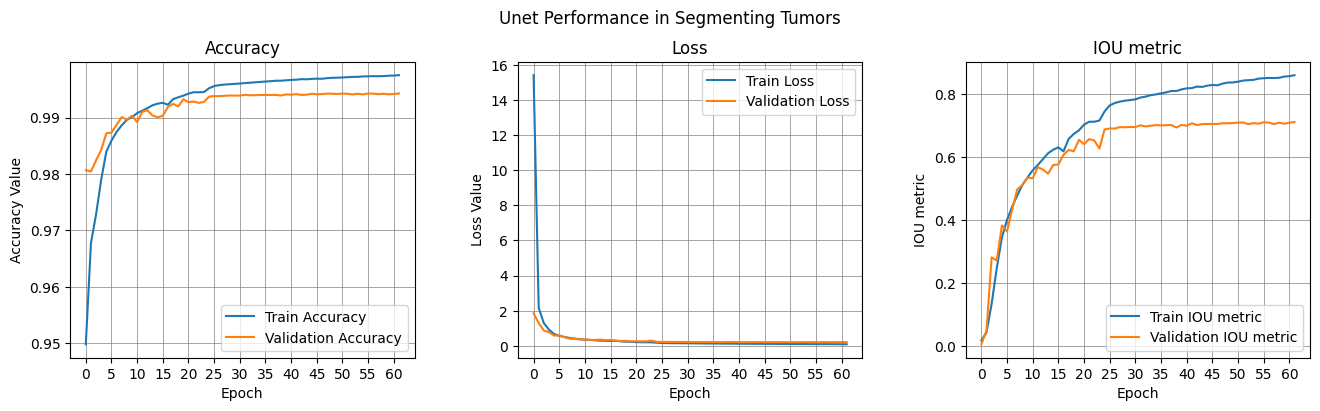

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [21]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step


Text(0.5, 1.0, 'Threshold vs IoU (0.7676767676767677, 0.8642293880939063)')

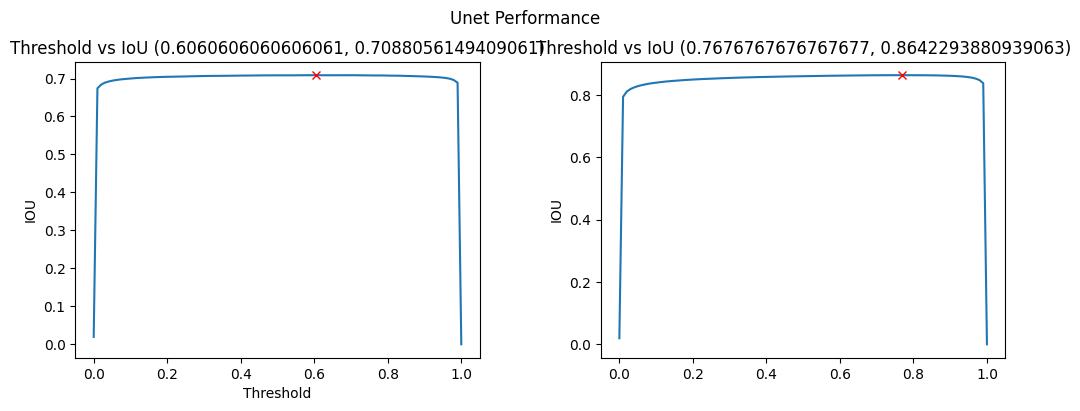

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


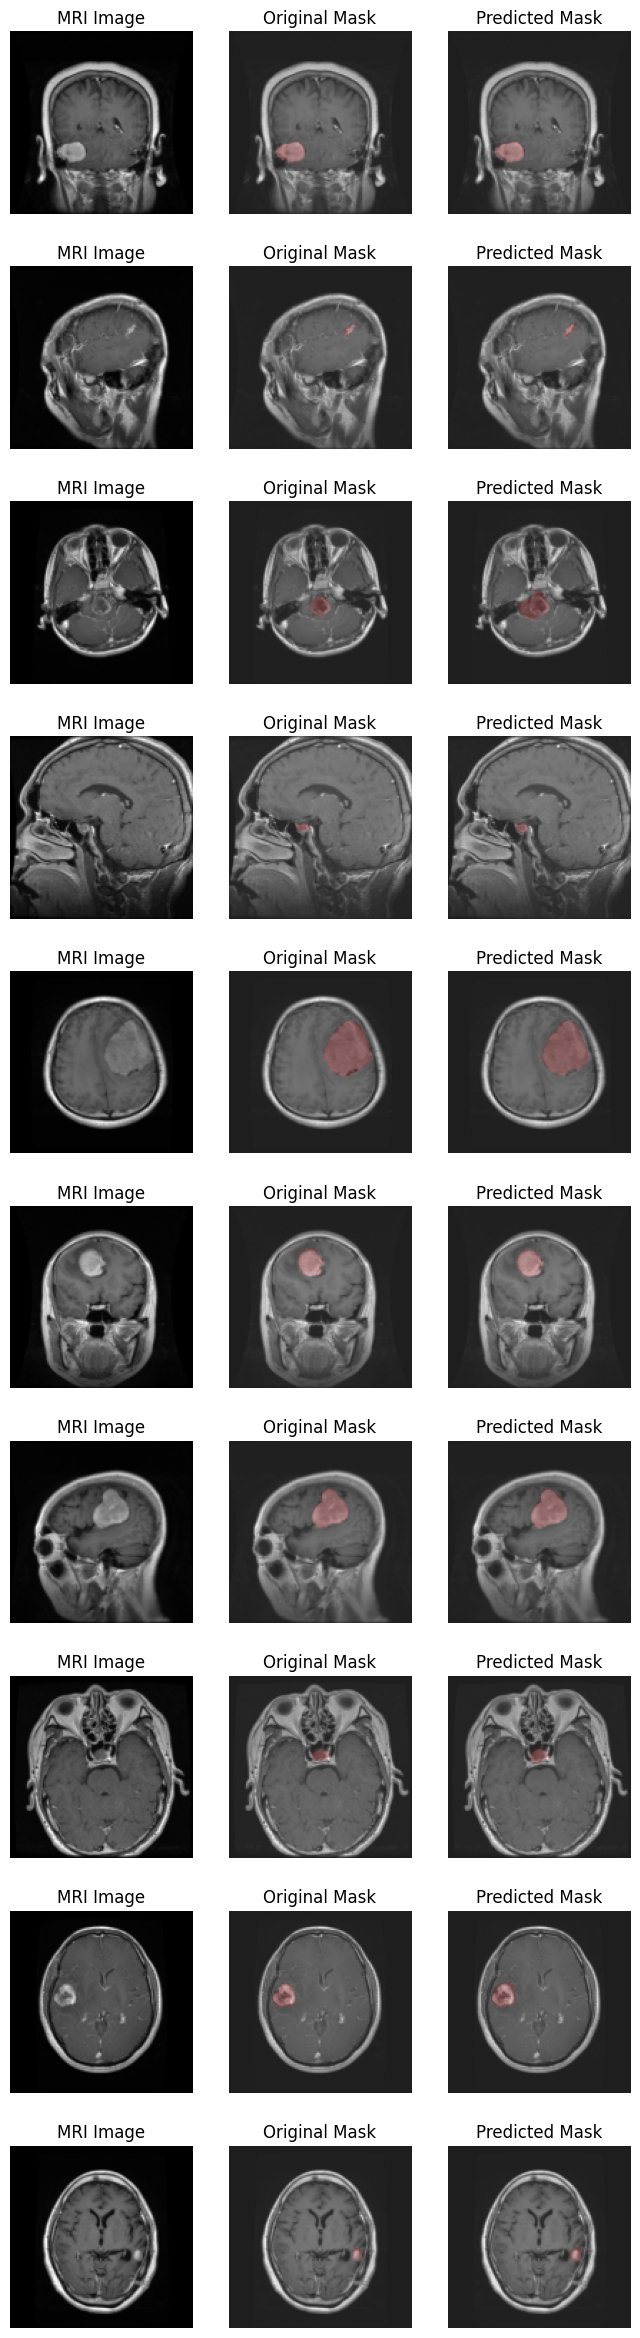

In [34]:
THRESHOLD = 0.76
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')